# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---

Homework 1 - MSc student Amedeo Giuliani

# Regression task

## Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

#for reproducible results
torch.manual_seed(2005797)

The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respactively the input and the target (label).

In [2]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

--2022-01-09 16:54:10--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv’

train_data.csv      100%[===================>]   3.69K  --.-KB/s    in 0s      

2022-01-09 16:54:12 (57.7 MB/s) - ‘regression_dataset/train_data.csv’ saved [3776/3776]

--2022-01-09 16:54:12--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regression_dataset/test_data.csv’

test_data.csv 

How to load the data:

In [2]:
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        # Read the file and split the lines in a list
        with open(csv_file, 'r') as f:
            lines = f.read().split('\n')
        # Get x and y values from each line and append to self.data
        self.data = []
        for line in lines[1:-1]:
            sample = line.split(',')
            self.data.append((float(sample[0]), float(sample[1])))
        # Now self.data contains all our dataset.
        # Each element of the list self.data is a tuple: (input, output)

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

In [3]:
composed_transform = transforms.Compose([ToTensor()])
train_dataset = CsvDataset('regression_dataset/train_data.csv', transform=composed_transform)
test_dataset = CsvDataset('regression_dataset/test_data.csv', transform=composed_transform)

train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')
#test_data = test_df.to_numpy()
#test_data = torch.tensor(test_data).float()

train_loader = DataLoader(train_dataset,batch_size=25, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset,batch_size=25, shuffle=False, num_workers=0)

In [4]:
class Net(torch.nn.Module):
  def __init__(self,num_input,num_h1,num_h2,num_output,p):
    super().__init__()
    self.hidden1 = torch.nn.Linear(num_input,num_h1)
    self.hidden2 = torch.nn.Linear(num_h1,num_h2)
    self.output = torch.nn.Linear(num_h2,num_output)
    self.act = torch.nn.Sigmoid()
    self.dropout = torch.nn.Dropout(p)

  def forward(self,x,additional_out=False):
    x = self.act(self.hidden1(x))
    x = self.dropout(x)
    x = self.act(self.hidden2(x))
    x = self.dropout(x)
    out = self.output(x)
    return out

In [38]:
!pip install skorch
from skorch import NeuralNetRegressor

net = NeuralNetRegressor(
    Net,
    module__num_input=1,
    module__num_output=1,
    module__num_h1=100,
    module__num_h2=100,
    module__p=0,
    optimizer=torch.optim.Adam,
    #ptimizer__momentum=0.9,
    optimizer__weight_decay=1e-4,
    criterion=torch.nn.MSELoss(),
    max_epochs=5000,
    lr=1e-3,
    batch_size=25,
    device='cuda',
    verbose=0
)

X_train = train_df.input.to_numpy()
X_train = X_train.reshape(-1,1)
X_train = X_train.astype(np.float32)
y_train = train_df.label.to_numpy()
y_train = y_train.reshape(-1,1)
y_train = y_train.astype(np.float32)
net.fit(X_train,y_train)

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (hidden1): Linear(in_features=1, out_features=100, bias=True)
    (hidden2): Linear(in_features=100, out_features=100, bias=True)
    (output): Linear(in_features=100, out_features=1, bias=True)
    (act): Sigmoid()
    (dropout): Dropout(p=0, inplace=False)
  ),
)

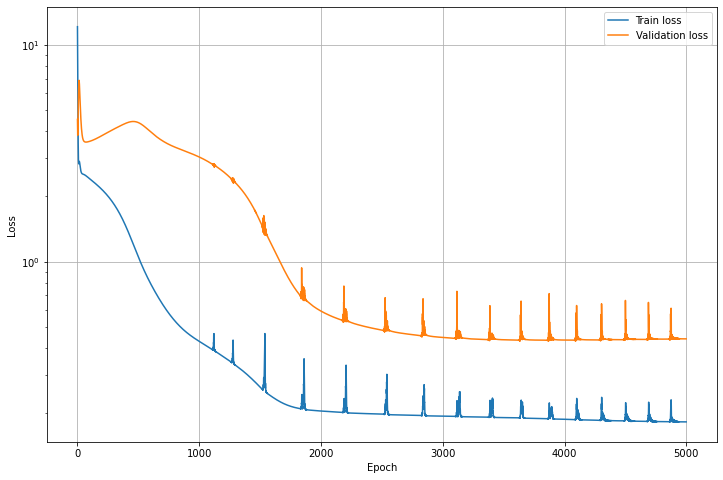

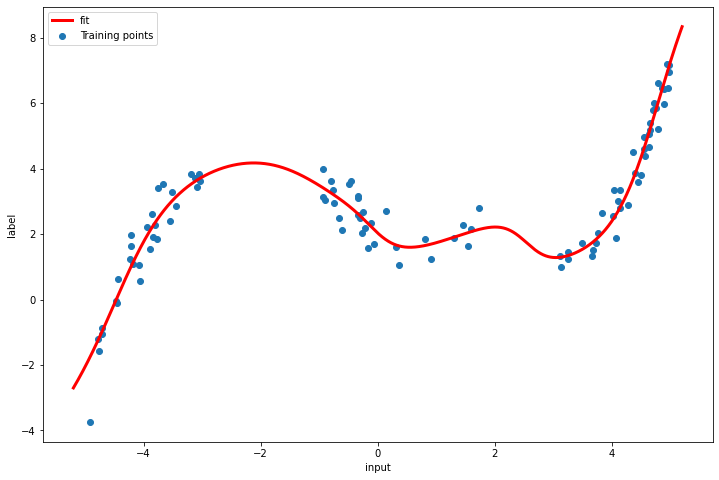

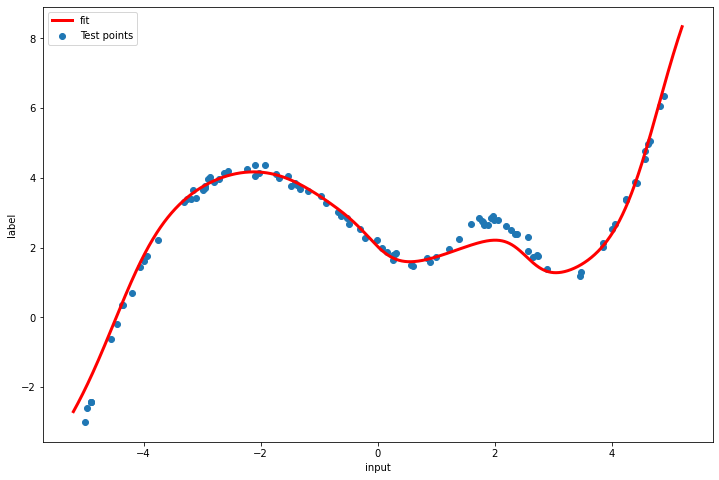

In [39]:
train_loss_log = net.history[:,'train_loss']
val_loss_log = net.history[:,'valid_loss']

# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig('trainvalloss_ffn.png')

#X_test = test_df.input.to_numpy().astype(float)
#X_test = X_test.reshape(-1,1)
#X_test = torch.tensor(X_test).float()

if torch.cuda.is_available():
  device = torch.device('cuda')

input = torch.linspace(-5.2,5.2,2000)
input = input.to(device)
input = input.unsqueeze(-1)  # Adding a dimension to the input vector
fit = net.predict(input)

input = input.squeeze().cpu().numpy()

fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.plot(input,fit,label='fit',color='red',lw=3)
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.savefig('fitvstrain_ffn.png')

fig = plt.figure(figsize=(12,8))
plt.scatter(test_df.input, test_df.label, label='Test points')
plt.plot(input,fit,label='fit',color='red',lw=3)
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.savefig('fitvstest_ffn.png')

In [40]:
X_test = test_df.input.to_numpy()
X_test = X_test.reshape(-1,1)
X_test = torch.tensor(X_test).float()
pred = net.predict(X_test)
pred = torch.tensor(pred).float()

y_test = test_df.label.to_numpy()
y_test = y_test.reshape(-1,1)
y_test = torch.tensor(y_test).float()

mse = torch.nn.MSELoss()
print('Test loss:',mse(y_test,pred))

Test loss: tensor(0.0976)


In [8]:
from sklearn.model_selection import GridSearchCV

net = NeuralNetRegressor(
    Net,
    module__num_input=1,
    module__num_output=1,
    optimizer=torch.optim.Adam,
    lr=1e-3,
    max_epochs=5000,
    train_split=None,
    verbose=0,
    device='cuda',
)

params = {
    'module__num_h1': [80,100],
    'module__num_h2': [80,100],
    'module__p': [0,0.25,0.5],
    'optimizer__weight_decay': [0,1e-5,1e-4],
    'batch_size': [10,25],
    #'max_epochs': [2000,4000,5000]
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='neg_root_mean_squared_error',verbose=2,error_score='raise')

X_train = train_df.input.to_numpy()
X_train = X_train.reshape(-1,1)
X_train = X_train.astype(np.float32)
y_train = train_df.label.to_numpy()
y_train = y_train.reshape(-1,1)
y_train = y_train.astype(np.float32)

gs.fit(X_train, y_train)
print(gs.best_score_, gs.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END batch_size=10, module__num_h1=80, module__num_h2=80, module__p=0, optimizer__weight_decay=0; total time= 1.5min
[CV] END batch_size=10, module__num_h1=80, module__num_h2=80, module__p=0, optimizer__weight_decay=0; total time= 1.5min
[CV] END batch_size=10, module__num_h1=80, module__num_h2=80, module__p=0, optimizer__weight_decay=0; total time= 1.5min
[CV] END batch_size=10, module__num_h1=80, module__num_h2=80, module__p=0, optimizer__weight_decay=1e-05; total time= 1.5min
[CV] END batch_size=10, module__num_h1=80, module__num_h2=80, module__p=0, optimizer__weight_decay=1e-05; total time= 1.5min
[CV] END batch_size=10, module__num_h1=80, module__num_h2=80, module__p=0, optimizer__weight_decay=1e-05; total time= 1.5min
[CV] END batch_size=10, module__num_h1=80, module__num_h2=80, module__p=0, optimizer__weight_decay=0.0001; total time= 1.5min
[CV] END batch_size=10, module__num_h1=80, module__num_h2=80, module__p=0,

In [ ]:
print('Best score and parameters combination')
print(gs.best_score_, gs.best_params_)

Best score and parameters combination
-1.9615515271822612 {'batch_size': 10, 'module__num_h1': 100, 'module__num_h2': 80, 'module__p': 0, 'optimizer__weight_decay': 0}


(array([ 2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,
         0.,  0.,  2.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  2.,  5.,  2.,
         7.,  1.,  0.,  0.,  3.,  6.,  4.,  2., 10.,  3.,  2.,  2.,  3.,
         0.,  2.,  1.,  2.,  8.,  1.,  0.,  0.,  0.,  0.,  2.]),
 array([-1.3788251 , -1.3329195 , -1.2870139 , -1.2411083 , -1.1952027 ,
        -1.1492971 , -1.1033915 , -1.0574859 , -1.0115803 , -0.96567476,
        -0.91976917, -0.8738636 , -0.827958  , -0.7820524 , -0.7361468 ,
        -0.6902412 , -0.6443356 , -0.59843004, -0.55252445, -0.50661886,
        -0.4607133 , -0.4148077 , -0.36890212, -0.32299653, -0.27709094,
        -0.23118535, -0.18527976, -0.13937417, -0.09346858, -0.04756299,
        -0.0016574 ,  0.04424819,  0.09015378,  0.13605936,  0.18196495,
         0.22787054,  0.27377614,  0.31968173,  0.3655873 ,  0.41149288,
         0.45739847,  0.50330406,  0.54920965,  0.59511524,  0.64102083,
         0.6869264 ,  0.732832  ,  0.7787376 ,  0.8246432 ,

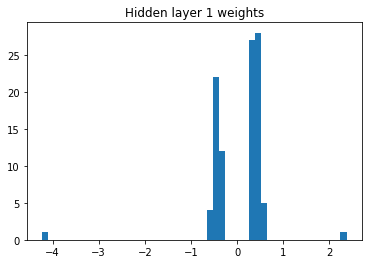

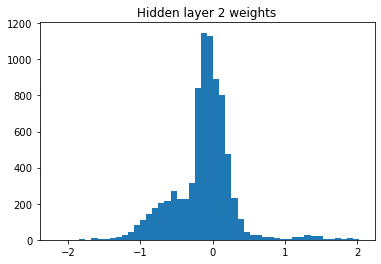

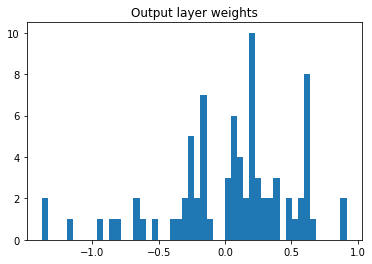

In [14]:
net.save_params(f_params='params.pth')
regressor = Net(1,100,80,1,0)
regressor.load_state_dict(torch.load('params.pth'))
plt.figure()
plt.title('Hidden layer 1 weights')
plt.hist(regressor.hidden1.weight.detach().numpy().flatten(),50)
plt.figure()
plt.title('Hidden layer 2 weights')
plt.hist(regressor.hidden2.weight.detach().numpy().flatten(),50)
plt.figure()
plt.title('Output layer weights')
plt.hist(regressor.output.weight.detach().numpy().flatten(),50)

# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Dataset

In [1]:
!pip install skorch
from skorch import NeuralNetClassifier
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn

torch.manual_seed(2005797) #for reproducible results

Download the dataset:

In [2]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=torchvision.transforms.ToTensor())

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
train_dataloader = DataLoader(train_dataset,batch_size=600, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset,batch_size=len(test_dataset), shuffle=False, num_workers=0)

In [4]:
class Net(torch.nn.Module):
  def __init__(self, encoded_space_dim, p):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True),
            nn.Dropout2d(p),
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=288, out_features=64),
            nn.ReLU(True),
            nn.Dropout(p),
            # Second linear layer
            nn.Linear(in_features=64, out_features=encoded_space_dim),
            nn.Softmax(dim=-1)
        )
        
  def forward(self, x):
      # Apply convolutions
      x = self.encoder_cnn(x)
      # Flatten
      x = self.flatten(x)
      # # Apply linear layers
      x = self.encoder_lin(x)
      return x

In [17]:
net = NeuralNetClassifier(
    Net,
    module__encoded_space_dim=10,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-4,
    lr=1e-3,
    criterion=nn.CrossEntropyLoss(),
    max_epochs=50,
    module__p=0,
    batch_size=300,
    device='cuda',
    verbose=2
)
print(net)

train_dataloader = DataLoader(train_dataset,batch_size=len(train_dataset), shuffle=False, num_workers=0)
dataiter = iter(train_dataloader)
images,labels = dataiter.next()
images = images.numpy()
labels = labels.numpy()
net.fit(images,labels)

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.Net'>,
  module__encoded_space_dim=10,
  module__p=0,
)
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8938       0.7344        1.7283  1.6009
      2        1.7083       0.7839        1.6818  1.6001
      3        1.6796       0.7997        1.6644  1.5909
      4        1.6629       0.8095        1.6530  1.5924
      5        1.6506       0.8187        1.6430  1.5925
      6        1.6431       0.8227        1.6396  1.5937
      7        1.6383       0.8254        1.6365  1.6215
      8        1.6337       0.8312        1.6309  1.5972
      9        1.6306       0.8293        1.6324  1.5991
     10        1.6278       0.8341        1.6267  1.5969
     11        1.6239       0.8373        1.6233  1.5969
     12        1.6222       0.8438        1.6179  1.5948
     13        1.6183       0.8438        1.6179  1.5952

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (encoder_cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Dropout2d(p=0, inplace=False)
      (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): Dropout2d(p=0, inplace=False)
      (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (7): ReLU(inplace=True)
      (8): Dropout2d(p=0, inplace=False)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_lin): Sequential(
      (0): Linear(in_features=288, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=64, out_features=10, bias=True)
      (4): Softmax(dim=-1)
    )
  ),
)

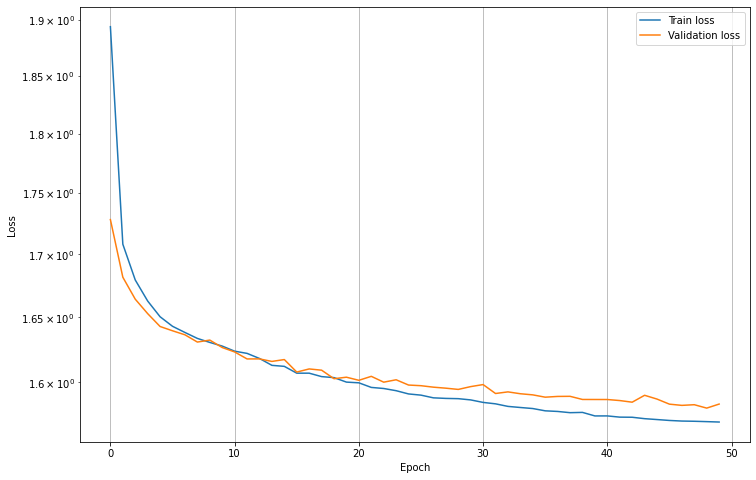

In [18]:
train_loss_log = net.history[:,'train_loss']
val_loss_log = net.history[:,'valid_loss']

# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig('traintestloss_cnn.png')

In [19]:
from sklearn.metrics import accuracy_score

dataiter = iter(test_dataloader)
images,labels = dataiter.next()
images = images.numpy()
labels = labels.numpy()

outputs = net.predict(images)
print('Test accuracy: '+str(accuracy_score(outputs,labels.tolist())*100)+'%')
print('Test accuracy: '+str(net.score(images,labels)*100)+'%')

Test accuracy: 86.77%
Test accuracy: 86.77%


In [7]:
from sklearn.model_selection import GridSearchCV

net = NeuralNetClassifier(
    Net,
    module__encoded_space_dim=10,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss(),
    max_epochs=50,
    train_split=None,
    verbose=0,
    device='cuda'
)

params = {
    'batch_size': [300,600],
    'module__p': [0,0.25,0.5],
    'optimizer__weight_decay': [0,1e-5,1e-4]
}

gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy',verbose=2,error_score='raise')

train_dataloader = DataLoader(train_dataset,batch_size=len(train_dataset), shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset,batch_size=len(test_dataset), shuffle=False, num_workers=0)

dataiter = iter(train_dataloader)
X_train, y_train = dataiter.next()
X_train = X_train.numpy()
y_train = y_train.numpy()

gs.fit(X_train, y_train)
print(gs.best_score_, gs.best_params_)

(60000, 1, 28, 28) (60000,)
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END batch_size=300, module__p=0, optimizer__weight_decay=0; total time=  56.5s
[CV] END batch_size=300, module__p=0, optimizer__weight_decay=0; total time=  54.8s
[CV] END batch_size=300, module__p=0, optimizer__weight_decay=0; total time=  54.7s
[CV] END batch_size=300, module__p=0, optimizer__weight_decay=1e-05; total time=  54.7s
[CV] END batch_size=300, module__p=0, optimizer__weight_decay=1e-05; total time=  54.3s
[CV] END batch_size=300, module__p=0, optimizer__weight_decay=1e-05; total time=  54.4s
[CV] END batch_size=300, module__p=0, optimizer__weight_decay=0.0001; total time=  54.5s
[CV] END batch_size=300, module__p=0, optimizer__weight_decay=0.0001; total time=  54.4s
[CV] END batch_size=300, module__p=0, optimizer__weight_decay=0.0001; total time=  54.4s
[CV] END batch_size=300, module__p=0.25, optimizer__weight_decay=0; total time=  55.7s
[CV] END batch_size=300, module__p=0.25, 

In [8]:
print('Best parameters:')
print(gs.best_score_, gs.best_params_)

Best parameters:
0.8723166666666667 {'batch_size': 300, 'module__p': 0, 'optimizer__weight_decay': 0.0001}


In [12]:
net.save_params(f_params='params.pth')
classifier = Net(10,0)
classifier.load_state_dict(torch.load('params.pth'))

<All keys matched successfully>

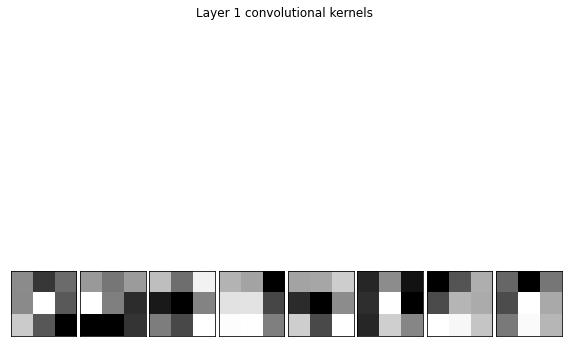

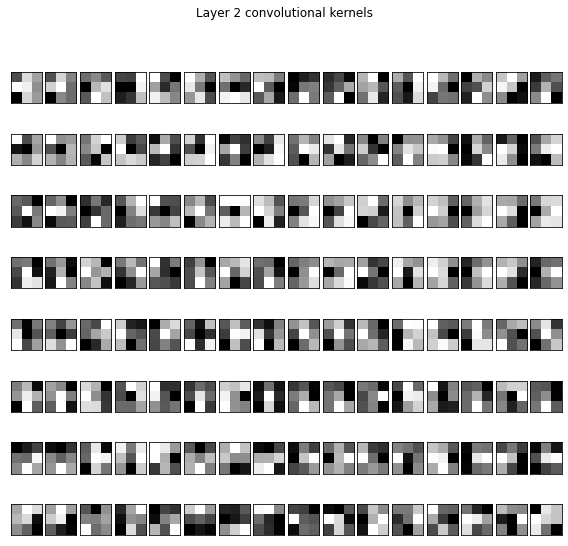

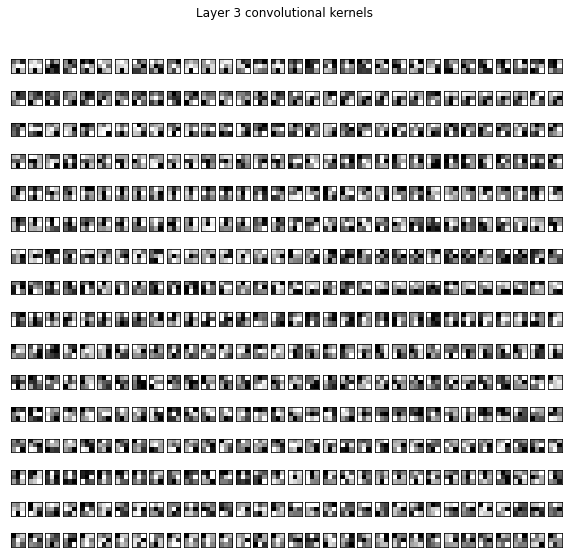

In [13]:
weights_l1 = classifier.encoder_cnn[0].weight.data.cpu().numpy()
weights_l2 = classifier.encoder_cnn[3].weight.data.cpu().numpy()
weights_l3 = classifier.encoder_cnn[6].weight.data.cpu().numpy()

### Plot the weights (this is a utility function, no need to analyze this code)
def plot_nchw_data(data, h_num, v_num, title):
    fig, axs = plt.subplots(h_num, v_num, figsize=(8,8))
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=0, w_pad=0)
    plt.show()

plot_nchw_data(weights_l1, 1, 8, 'Layer 1 convolutional kernels')
plot_nchw_data(weights_l2, 8, 16, 'Layer 2 convolutional kernels')
plot_nchw_data(weights_l3, 16, 32, 'Layer 3 convolutional kernels')

Net(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout2d(p=0, inplace=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Dropout2d(p=0, inplace=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU(inplace=True)
    (8): Dropout2d(p=0, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
    (4): Softmax(dim=-1)
  )
)


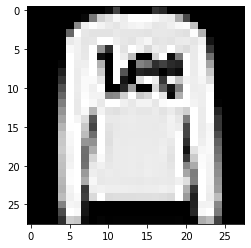

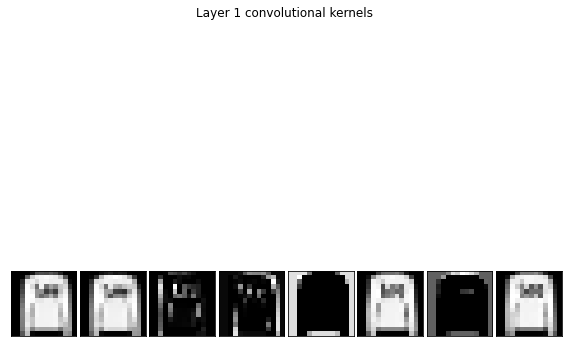

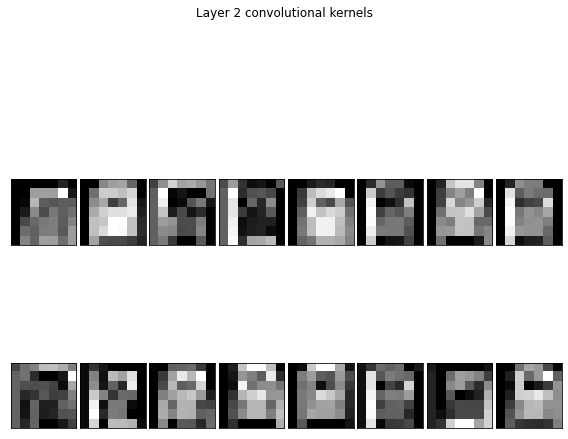

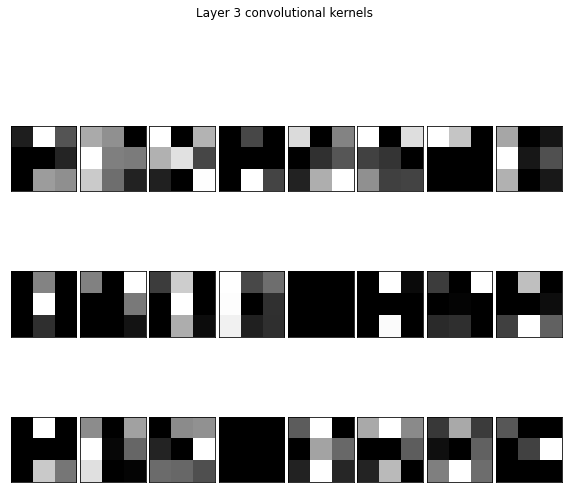

In [14]:
# Hook function to call during forward pass
def hook_fn(module, input, output):
    intermediate_outputs.append(output)

# Attach hook function to all the convolutional layers
hook_handles = [] # This list will contains all the handles required to remove the hooks later
hook_handles.append(classifier.encoder_cnn[0].register_forward_hook(hook_fn))
hook_handles.append(classifier.encoder_cnn[3].register_forward_hook(hook_fn))
hook_handles.append(classifier.encoder_cnn[6].register_forward_hook(hook_fn))

device = 'cuda'

# Define input
net_input = test_dataset[1][0].unsqueeze(0)
net_input = net_input.to(device)

# Show original image
plt.imshow(test_dataset[1][0].squeeze(),cmap='gist_gray')

classifier.to(device)
print(classifier)

# Evaluate output
classifier.eval()
with torch.no_grad():
    intermediate_outputs = []
    out = classifier(net_input)
    # Now the intermediate_outputs list contains the intermediate outputs thanks to the hook function

# Analyze intermediate outputs
for layer_num, intermediate_output in enumerate(intermediate_outputs):
    intermediate_output = intermediate_output.cpu().data.numpy()
    # Plot
    plot_nchw_data(intermediate_output, layer_num+1, 8, 'Layer %d convolutional kernels' % (layer_num + 1))

In [15]:
# Remove the hooks using the handles saved during the hooks definition
for handle in hook_handles:
  handle.remove()